Find the average of getFlowBytes

In [ ]:
// c++ run on https://cpp.sh/
#include <iostream>
#include <string>
#include <random>

int main()
{
    int mean_bytes = 100.0 * 1024;
    double shape = 1.05;
    double scale = mean_bytes * (shape - 1)/shape;
    std::exponential_distribution<double> exp_distribution = std::exponential_distribution<double>(shape);
    std::default_random_engine generator;

    int large_flow_threshold = 10 * 1024 * 1024;
    int count = 50000;
    int sum = 0;
    double x = 0;
    int bytes = 0;
    for (int i=0; i<count; i++) {
        x = exp_distribution(generator);
        bytes = scale * exp(x);
        while (bytes<0 or bytes>large_flow_threshold){
            x = exp_distribution(generator);
            bytes = scale * exp(x);
        }
        sum += bytes;
    }
    
    std::cout << "average=" << sum/(double)count << std::endl;
}

Check whether the pathweightfiles exist

In [5]:
import os

conffile = "/home/annzhou/DRing/src/emp/datacentre/experiments/rerun_sigcomm24/r2r0.conf"
with open(conffile,'r') as f:
    lines = f.readlines()
    for line in lines:
        tokens = line.split()
        pwfile = tokens[23]
        if not os.path.exists(f"/home/annzhou/DRing/src/emp/datacentre/{pwfile}"):
            print(f"File not exist: {pwfile}")


In [28]:
import os

conffile = "/home/annzhou/DRing/src/emp/datacentre/experiments/rerun_sigcomm24/clusterb.conf"
with open(conffile,'r') as f:
    lines = f.readlines()
    for line in lines:
        tokens = line.split()
        solvestart = int(tokens[12])
        solveend = int(tokens[13])
        solveinterval = int(tokens[14])
        computestart = int(tokens[15])
        computeinterval = int(tokens[17])
        pwfile = tokens[23]
        dp = tokens[24]
        numintervals = int((solveend-solvestart)/solveinterval)+1
        # print(numintervals)
        for i in range(numintervals):
            if computeinterval == 0:
                mypwfile = pwfile
            else:
                mypwfile = f"{pwfile}{computestart+i*solveinterval}_{computestart+i*solveinterval+computeinterval}_{dp}.txt"
            if not os.path.exists(f"/home/annzhou/DRing/src/emp/datacentre/{mypwfile}"):
                print(f"File not exist: {mypwfile}")


Store into picklefile and produce sumfile

In [8]:
trafficname = "r2r0"

import pickle

conffile = f"/home/annzhou/DRing/src/emp/datacentre/experiments/rerun_sigcomm24/{trafficname}.conf"
sumfile = f"/home/annzhou/DRing/src/emp/datacentre/experiments/rerun_sigcomm24/{trafficname}.txt"
datadict = dict()
with open(conffile,'r') as f:
    with open(sumfile,'a') as sumf:
        lines = f.readlines()
        for line in lines:
            tokens = line.split()
            logfile = tokens[29]
            sizelist = list()
            durationlist = list()
            startlist = list()
            with open(f"/home/annzhou/DRing/src/emp/datacentre/{logfile}",'r') as logf:
                loglines = logf.readlines()
                for logline in loglines:
                    logtokens = logline.split()
                    if logtokens[0] == "FCT":
                        durationlist.append(float(logtokens[2]))
                        sizelist.append(int(logtokens[1]))
                        startlist.append(float(logtokens[3]))
            datadict[logfile] = [durationlist,sizelist,startlist]
            durationlist.sort()
            sumf.write(f"{logfile}\t{sum(durationlist)/len(durationlist)}\t{durationlist[int(len(durationlist)*0.5)]}\t{durationlist[int(len(durationlist)*0.99)]}\t{durationlist[int(len(durationlist)*0.9999)]}\n")

with open(f'/home/annzhou/DRing/src/emp/datacentre/experiments/rerun_sigcomm24/{trafficname}.pickle', 'wb') as handle:
    pickle.dump(datadict, handle, protocol=pickle.HIGHEST_PROTOCOL)

Delete logfiles

In [9]:
import os

conffile = "/home/annzhou/DRing/src/emp/datacentre/experiments/rerun_sigcomm24/r2r0.conf"
with open(conffile,'r') as f:
    lines = f.readlines()
    for line in lines:
        tokens = line.split()
        logfile = tokens[29]
        os.remove(f"/home/annzhou/DRing/src/emp/datacentre/{logfile}")

Test correctness plot cwnd

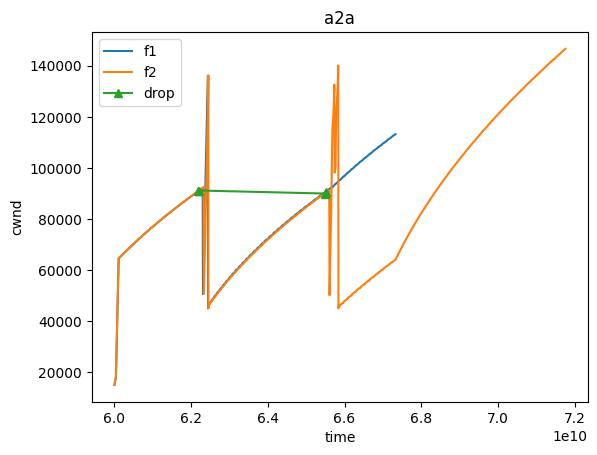

In [5]:
logfile = "/home/annzhou/DRing/src/emp/datacentre/m_testcor_rrg_ecmp_a2a_equal.log"
timelist1 = list()
cwndlist1 = list()
timelist2 = list()
cwndlist2 = list()
timelist3 = list()
droplist3 = list()
with open(logfile,'r') as f:
    lines = f.readlines()
    for line in lines:
        if len(line.split(','))==3 and len(line.split(',')[1].split('='))==2 and line.split(',')[1].split('=')[0]=="flowsize":
            tokens = line.split(',')
            now = int(tokens[0].split('=')[1])
            size = int(tokens[1].split('=')[1])
            cwnd = int(tokens[2].split('=')[1])
            if size==5245500:
                timelist1.append(now)
                cwndlist1.append(cwnd)
            elif size==10488000:
                timelist2.append(now)
                cwndlist2.append(cwnd)
            else:
                print(f"Error: flowsize={size}")
        if len(line.split(','))==3 and line.split(',')[1]=="drop":
            timelist3.append(now)
            droplist3.append(cwnd)

import matplotlib
import matplotlib.pyplot as plt

plt.plot(timelist1,cwndlist1,label="f1")
plt.plot(timelist2,cwndlist2,label="f2")
plt.plot(timelist3,droplist3,label="drop",marker="^")
plt.legend()
plt.xlabel("time")
plt.ylabel("cwnd")
plt.title("a2a")
# plt.savefig(f"/home/annzhou/DRing/src/emp/datacentre/experiments/rerun_sigcomm24/a2a.png", bbox_inches='tight', dpi=500)
plt.show()
plt.close()

Calculate total traffic across all pairs of servers per cluster in the file

cluster a: total 6642540978 bytes
mult=6.232554701147679

cluster b: total 102766683282 bytes
mult=0.40285429750024226

cluster c: total 145701131197 bytes
mult=0.2841432984073663

In [ ]:
myclusterstr = "c"

clusterfilesuffix = dict()
clusterfilesuffix["a"] = ["_0_273"]
clusterfilesuffix["b"] = ["_0_500","_500_1000","_1000_1500","_1500_2000","_2000_2500","_2500_2900"]
clusterfilesuffix["c"] = ["_0_273"]

totalbytes = 0
for suffix in clusterfilesuffix[myclusterstr]:
  with open(f"/home/annzhou/DRing/src/emp/datacentre/trafficfiles/cluster_{myclusterstr}/traffic_64racks{suffix}",'r') as f:
    lines = f.readlines()
    for line in lines:
      tokens = line.split()
      mybytes = int(tokens[1])
      totalbytes += mybytes
print(f"cluster {myclusterstr}: total {totalbytes} bytes")


target = 41.4*1e9 # bytes, for 150ms
mult = target/totalbytes
print(f"mult={mult}")

Bulk untar rrg su3 cluster* dbr

In [27]:
commandstr = ""
# clustername = "a"
# strarr = ["0","1","2","3","4","5","6","7_0","7_1","8","9"]
clustername = "b"
strarr = ["0","1","2","3","4","5_0","5_1","6","7_0","7_1","8","9"]

for mystr in strarr:
    if commandstr != "": commandstr += " && "
    commandstr += f"tar -zxvf rrg_su3_cluster{clustername}_dbr{mystr}.tar.gz"
print(commandstr)

tar -zxvf rrg_su3_clusterb_dbr0.tar.gz && tar -zxvf rrg_su3_clusterb_dbr1.tar.gz && tar -zxvf rrg_su3_clusterb_dbr2.tar.gz && tar -zxvf rrg_su3_clusterb_dbr3.tar.gz && tar -zxvf rrg_su3_clusterb_dbr4.tar.gz && tar -zxvf rrg_su3_clusterb_dbr5_0.tar.gz && tar -zxvf rrg_su3_clusterb_dbr5_1.tar.gz && tar -zxvf rrg_su3_clusterb_dbr6.tar.gz && tar -zxvf rrg_su3_clusterb_dbr7_0.tar.gz && tar -zxvf rrg_su3_clusterb_dbr7_1.tar.gz && tar -zxvf rrg_su3_clusterb_dbr8.tar.gz && tar -zxvf rrg_su3_clusterb_dbr9.tar.gz
